In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import glob
from sklearn import preprocessing
from pysptools import spectro as sp
from pysptools import distance
from IPython.display import display
import ipywidgets as widgets
from math import*

In [87]:
### https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/
### https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

class Widegets:
    def on_value_change_min(change):
        new_min = change['new']
        if new_min + 100 > maxWavelength.value:
            minWavelength.value = maxWavelength.value - 100

    def on_value_change_max(change):
        new_max = change['new']
        if minWavelength.value > new_max - 100:
            maxWavelength.value = minWavelength.value + 100
        
        
class FolderAndFileProcessing:
    def ReadFilePaths(source, ext):
        return glob.glob(source + "/**/*." + ext, recursive = True)
    
    def ReadFile(file, rowToSkip, seperation):
        return pd.read_csv(file ,skiprows = rowToSkip, sep = seperation) 
    
    def GetValuesFromFile(file, rowToSkip, seperation, column):
        fileData = FolderAndFileProcessing.ReadFile(file , rowToSkip, seperation)
        return fileData[column]
    
    def WriteDictToExcel(targetPath, filename, dictionary):
        df = pd.DataFrame.from_dict(dictionary)
        os.makedirs(targetPath, exist_ok=True)
        df.to_excel(targetPath+filename)
        
class SpectraComparision:
    
    def MeanSquareRootComparision(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            result = spectraValue[minIndex:maxIndex] - idealReflectance[minIndex:maxIndex]
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def MeanSquareRootComparisionNormalized(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            #print(idealReflectance, fileList[index])
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            result = normalized_spectraValue[minIndex:maxIndex] - normalized_idealReflectance[minIndex:maxIndex]
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def CrossCorrelation(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            result = np.corrcoef(normalized_spectraValue[minIndex:maxIndex], normalized_idealReflectance[minIndex:maxIndex])
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CrossCorrelationContinumRemoved(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        waveLength = list(range(350,2501))
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
            result = np.corrcoef(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CrossCorrelationContinumRemovedFaster(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.corrcoef(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def MeanSquareRootContinumRemovedFaster(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.array(continumRemoved_spectraValue[minIndex:maxIndex]) - np.array(continumRemoved_idealReflectance[minIndex:maxIndex])
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def CosineSimilarityContinumRemoved(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = SpectraComparision.cosine_similarity(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def computeSimilarityContinumRemoved(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = SpectraComparision.compute_similarity(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def SAM(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SAM(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore

    def chebyshev(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.chebyshev(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore

    def SpectralInformationDivergence(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SID(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def compute_similarity(ref_rec,input_rec,weightage=[0.33,0.33,0.33]):
        ref_rec = np.array(ref_rec)
        input_rec = np.array(input_rec)
        ## Time domain similarity
        ref_time = np.correlate(ref_rec,ref_rec)    
        inp_time = np.correlate(ref_rec,input_rec)
        diff_time = abs(ref_time-inp_time)

        ## Freq domain similarity
        ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
        inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
        diff_freq = abs(ref_freq-inp_freq)

        ## Power similarity
        ref_power = np.sum(ref_rec**2)
        inp_power = np.sum(input_rec**2)
        diff_power = abs(ref_power-inp_power)
        
        return float(weightage[0]*diff_time+weightage[1]*diff_freq+weightage[2]*diff_power)
    

    
    def square_rooted(x):
        return round(sqrt(sum([a*a for a in x])),3)
 
    def cosine_similarity(x,y):
        numerator = sum(a*b for a,b in zip(x,y))
        denominator = SpectraComparision.square_rooted(x)* SpectraComparision.square_rooted(y)
        return round(numerator/float(denominator),3)

### Variable Declarations

In [88]:
##txt file declarations
txtPath = "../data/enviData/cleanFolder/"
extensionTxt= 'txt'

###sed file declarations
sedPath = "../data/vulcano/"
extensionSed= 'sed'

###Descibing wavelengths
minWavelength = widgets.IntSlider(value=350, min=350, max=2500)
maxWavelength = widgets.IntSlider(value=2500, min=350, max=2500)
minWavelength.description = 'min wav'
maxWavelength.description = 'max wav'
        
minWavelength.observe(Widegets.on_value_change_min, names='value')
maxWavelength.observe(Widegets.on_value_change_max, names='value')

### Select the wavelength range

In [97]:
display(minWavelength, maxWavelength)

IntSlider(value=1300, description='min wav', max=2500, min=350)

IntSlider(value=1600, description='max wav', max=2500, min=350)

In [130]:
minIndex = minWavelength.value - 350
maxIndex = maxWavelength.value - 350 + 1

In [131]:
maxIndex

1921

### Populating paths

In [92]:
txt_files = FolderAndFileProcessing.ReadFilePaths(txtPath,extensionTxt)
sed_files = FolderAndFileProcessing.ReadFilePaths(sedPath,extensionSed)

### Running Algorithm

In [93]:
waveLength = list(range(350,2501))

In [94]:
fileListContinumRemoval = []
counter = 0
for index in range(len(txt_files)):
    idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
    normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
    continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
    fileListContinumRemoval.append(continumRemoved_idealReflectance)
    counter = counter + 1
    print('processed ' + str(counter))

processed 1
processed 2
processed 3
processed 4
processed 5
processed 6
processed 7
processed 8
processed 9
processed 10
processed 11
processed 12
processed 13
processed 14
processed 15
processed 16
processed 17
processed 18
processed 19
processed 20
processed 21
processed 22
processed 23
processed 24
processed 25
processed 26
processed 27
processed 28
processed 29
processed 30
processed 31
processed 32
processed 33
processed 34
processed 35
processed 36
processed 37
processed 38
processed 39
processed 40
processed 41
processed 42
processed 43
processed 44
processed 45
processed 46
processed 47
processed 48
processed 49
processed 50
processed 51
processed 52
processed 53
processed 54
processed 55
processed 56
processed 57
processed 58
processed 59
processed 60
processed 61
processed 62
processed 63
processed 64
processed 65
processed 66
processed 67
processed 68
processed 69
processed 70
processed 71
processed 72
processed 73
processed 74
processed 75
processed 76
processed 77
processe

processed 595
processed 596
processed 597
processed 598
processed 599
processed 600
processed 601
processed 602
processed 603
processed 604
processed 605
processed 606
processed 607
processed 608
processed 609
processed 610
processed 611
processed 612
processed 613
processed 614
processed 615
processed 616
processed 617
processed 618
processed 619
processed 620
processed 621
processed 622
processed 623
processed 624
processed 625
processed 626
processed 627
processed 628
processed 629
processed 630
processed 631
processed 632
processed 633
processed 634
processed 635
processed 636
processed 637
processed 638
processed 639
processed 640
processed 641
processed 642
processed 643
processed 644
processed 645
processed 646
processed 647
processed 648
processed 649
processed 650
processed 651
processed 652
processed 653
processed 654
processed 655
processed 656
processed 657
processed 658
processed 659
processed 660
processed 661
processed 662
processed 663
processed 664
processed 665
proces

In [133]:
for index in range(len(sed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.MeanSquareRootContinumRemovedFaster(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = sed_files[index].replace('/data','/SFFOLD_2170_2270_images').split('/')[-1].replace('.sed','.xlsx')
    list_string = sed_files[index].replace('/data','/SFFOLD_2170_2270_images').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)
    
    
    
    
    try:
        limit = 6
        counterMineral = 0
        mineralNameList = [i for i,j in dictMineralValue]
        mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
        mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
        
        normalized_spectraValue = preprocessing.normalize([testData])[0]
        continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        
        
        xaxis = list(range(minWavelength.value,maxWavelength.value + 1))
        fig = plt.figure(figsize=(24, 12))
        plt.plot(xaxis, continumRemoved_spectraValue[minIndex:maxIndex], label = targetfilename.replace('.xlsx',''))
        
        indexForWhile = 0
        while counterMineral < limit:
            mineralName = dictMineralValue[indexForWhile][0]
            
            if mineralNameListDict[mineralName.split('_')[0]] == False:
                imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                signal = fileListContinumRemoval[txt_files.index(imagePath)]
                plt.plot(xaxis, signal[minIndex:maxIndex], label = mineralName)
                mineralNameListDict[mineralName.split('_')[0]] = True
                counterMineral = counterMineral + 1
            
            indexForWhile = indexForWhile + 1
        
        plt.legend(loc="upper left")
        plt.savefig(sed_files[index].replace('/data', '/SFFOLD_2170_2270_images').replace('sed','png'), dpi=500)
        plt.close()
    except:
        continue

co = 0
for index in range(len(txt_files)):
    idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
    normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
    continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
    
    plt.plot(continumRemoved_idealReflectance)
    plt.savefig(txt_files[index].replace('/data', '/imagesTest').replace('txt','png'), dpi=500)
    plt.close()
    
    co = co + 1
    print('processed ' + str(co))

### Testing Data

In [267]:
###sed file declarations
testSedPath = "../testMineral/"
testSed_files = FolderAndFileProcessing.ReadFilePaths(testSedPath,extensionTxt)

In [268]:
testSed_files

['../testMineral/s07_ASD_Microcline+others_HS107.3B_BECKa_AREF.txt',
 '../testMineral/s07_ASD_Alun366+.50PyroPYS1A_GDS222_BECKb_AREF.txt',
 '../testMineral/s07_ASD_Pyrophyl+Muscovite_JH_PYRM1_ASDFRb_AREF.txt',
 '../testMineral/s07_ASD_Chlorite.33+Epidot.67_GDS318_ASDFRa_AREF.txt',
 '../testMineral/s07_ASD_Cordierite-QtzMus_HS346.4B_ASDFRc_AREF.txt',
 '../testMineral/s07_ASD_Kaol_Wxl+0.5Musc_Ruby_AMX12_BECKa_AREF.txt',
 '../testMineral/s07_ASD_Muscovite-medlowAl_CU91-250A_ASDFRb_AREF.txt',
 '../testMineral/s07_ASD_Natrolite+Zeolite_HS168.3B_ASDFRb_AREF.txt',
 '../testMineral/s07_ASD_Alunite0.35K+.65Na_CU91-217H_ASDFRb_AREF.txt',
 '../testMineral/s07_ASD_White_Crust_LV30_starkeyite_ASDFRc_AREF.txt',
 '../testMineral/s07_ASD_Hematite.02+Quartz.98_GDS76_BECKa_AREF.txt',
 '../testMineral/s07_ASD_Gyp.4+jr20+msc.2+dic.2_AMX23_BECKa_AREF.txt',
 '../testMineral/s07_ASD_Alunite+Pyrophyl_SD1093A_BECKb_AREF.txt',
 '../testMineral/s07_ASD_Calcite.5+.Ca-Mont.5_AMX6_BECKb_AREF.txt',
 '../testMineral/

In [273]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 0, ' ','reflectance')
    dictMineralValue = SpectraComparision.computeSimilarityContinumRemoved(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = testSed_files[index].replace('/testMineral','/testDataScoreRemoved').split('/')[-1].replace('.txt','.xlsx')
    list_string = testSed_files[index].replace('/testMineral','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [189]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.CosineSimilarityContinumRemoved(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[-1].replace('.sed','.xlsx')
    list_string = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

KeyError: 'Reflect. [1.0]'

In [215]:
testSed_files[0]

'../testData/ASTRO_00010_00001.sed'

In [216]:
tt = pd.read_csv(testSed_files[0] ,skiprows = 26, sep = '\t')

In [217]:
ww = tt['Reflect. [1.0]']

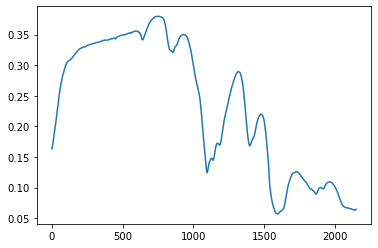

In [218]:
plt.plot(ww)

In [219]:
aa = sp.convex_hull_removal(ww,list(range(350,2501)))

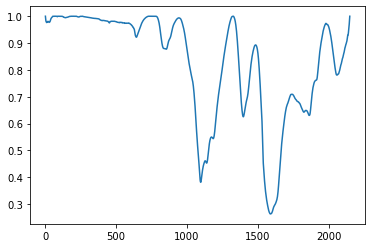

In [220]:
plt.plot(aa[0])

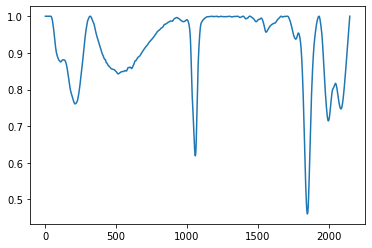

In [224]:
plt.plot(fileListContinumRemoval[0])

In [250]:
def compute_similarity(ref_rec,input_rec,weightage=[0.33,0.33,0.33]):
    ## Time domain similarity
    ref_time = np.correlate(ref_rec,ref_rec)    
    inp_time = np.correlate(ref_rec,input_rec)
    diff_time = abs(ref_time-inp_time)

    ## Freq domain similarity
    ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
    inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
    diff_freq = abs(ref_freq-inp_freq)

    ## Power similarity
    ref_power = np.sum(ref_rec**2)
    inp_power = np.sum(input_rec**2)
    diff_power = abs(ref_power-inp_power)

    return float(weightage[0]*diff_time+weightage[1]*diff_freq+weightage[2]*diff_power)

In [252]:
compute_similarity(np.array(fileListContinumRemoval[6]), np.array(aa[0]))

[78.69853829]
[169280.55586016]
54.89897330451822


55906.670612679336

In [237]:
aa[0]

[1.0,
 0.9935262814778876,
 0.9878433138226025,
 0.9840567004947919,
 0.9814041075737067,
 0.9796774616494033,
 0.9787344547998962,
 0.9778666857183681,
 0.9767323369565216,
 0.9764044471238099,
 0.9769715825439595,
 0.9782988619631479,
 0.9784019634578673,
 0.9778546432287092,
 0.9788168501111377,
 0.9799742545087786,
 0.9809533831421655,
 0.9809244409674686,
 0.980637489336401,
 0.980355472404116,
 0.9804848300045739,
 0.9804104360095239,
 0.9797376639600248,
 0.9787787564574275,
 0.9778356595242775,
 0.9773954157171929,
 0.9772040515386661,
 0.9772555602182125,
 0.9776392787477994,
 0.9781585188856242,
 0.9786696012550047,
 0.9787545447153528,
 0.9795297372060856,
 0.9812537887019477,
 0.9829061769312841,
 0.9847588793890034,
 0.986852108581906,
 0.9880707984242355,
 0.9891833542616701,
 0.9908918945515379,
 0.9919242792636331,
 0.9925537990711106,
 0.9930458970792768,
 0.994040853613197,
 0.995148293464962,
 0.9954442152006115,
 0.9959856064230296,
 0.9967673638006712,
 0.997169114

In [249]:
ref_time

NameError: name 'ref_time' is not defined